In [1]:
#%matplotlib inline
import config as cfg
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils

from imutils import paths
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from tqdm.notebook import tqdm

!jupyter nbextension enable --py widgetsnbextension

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Random Seed:  999


## Dataset Class

In [2]:
class SaltDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms) -> None:
        # store the image and mask filepaths
        # store the transforms
        self.imagePaths = image_paths
        self.maskPaths = mask_paths
        self.transforms = transforms
    
    def __len__(self):
        # return the total number of samples
        return len(self.imagePaths)
    
    def __getitem__(self, index):
        # grab the image path from current index
        imagePath = self.imagePaths[index]

        # load the image and its mask from disk
        image = Image.open(imagePath).convert('RGB')
        mask = ImageOps.grayscale(Image.open(self.maskPaths[index]))

        # check if we need to apply transformations
        if self.transforms is not None:
            # apply the transforms
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        # return a tuple of the image and its mask
        return (image, mask)

## Building the UNet

### Define a Block

In [3]:
class Block(nn.Module):
    def __init__(self, ic, oc) -> None:
        super().__init__()

        # store the convolution and ReLU layers
        # let input dims be (D,D)
        self.main = nn.Sequential(
            # state size. (ic)xDxD
            nn.Conv2d(in_channels=ic,
                        out_channels=oc,
                        kernel_size=3,
                        stride=1,
                        padding=0,
                        bias=False),
            nn.ReLU(True),
            # state size. (oc)x(D-2)x(D-2)
            nn.Conv2d(in_channels=oc,
                        out_channels=oc,
                        kernel_size=3,
                        stride=1,
                        padding=0,
                        bias=False),            
        )
        # state size. (oc)x(D-4)x(D-4)
    
    def forward(self, input):
        return self.main(input)

### Define the encoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, channels=(3, 16, 32, 64)) -> None:
        super().__init__()

        self.channels = channels
        # store encoder blocks and downsampling layer
        self.enc_blocks = nn.ModuleList(
            [Block(self.channels[i], self.channels[i+1]) 
                for i in range(len(self.channels)-1)]
        )
        self.downsample = nn.AvgPool2d(2)

    def forward(self, x):
        # store intermediate block outputs for skip connections
        block_outputs = []

        # loop through the encoder blocks
        for block in self.enc_blocks:
            # pass input ([ic]xDxD) to current encoder block
            x = block(x)
            # store the output of encoder block
            block_outputs.append(x)
            # downsample
            x = self.downsample(x)
            # state size. (oc)x(D-4)/2x(D-4)/2
        
        # return the block_outputs
        return block_outputs

### Define the decoder

In [5]:
class Decoder(nn.Module):
    def __init__(self, channels=(64,32,16)) -> None:
        super().__init__()

        self.channels = channels
        # store decoder blocks and transpose conv layers (for upsampling)
        self.dec_blocks = nn.ModuleList(
            [Block(self.channels[i], self.channels[i+1])
                for i in range(len(self.channels)-1)]
        )
        self.upsamplings = nn.ModuleList(
            [nn.ConvTranspose2d(in_channels=self.channels[i],
                                    out_channels=self.channels[i+1],
                                    kernel_size=2,
                                    stride=2,
                                    padding=0,
                                    bias=False)
                for i in range(len(self.channels)-1)]
        )
    
    def crop(self, enc_features, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        enc_features = transforms.CenterCrop([H, W])(enc_features)
        # return the cropped features
        return enc_features

    def forward(self,x,enc_features):
        # loop through number of channels
        for i in range(len(self.channels)-1):
            # pass the inputs through the upsampler block
            x = self.upsamplings[i](x)
            # crop the current features from the encoder block
            enc_feature = self.crop(enc_features[i], x)
            # concatenate to the current upsampled features
            x = torch.cat([x,enc_feature], dim=1)
            # pass concatenated features to decoder block
            x = self.dec_blocks[i](x)
        
        return x

### Define UNet

In [6]:
class UNet(nn.Module):
	def __init__(self, enc_channels=(3, 16, 32, 64),
		 dec_channels=(64, 32, 16),
		 nb_classes=1, retain_dim=True,
		 out_size=(cfg.INPUT_IMAGE_HEIGHT,  cfg.INPUT_IMAGE_WIDTH)):
		super().__init__()
		
		# initialize the encoder and decoder
		self.encoder = Encoder(enc_channels)
		self.decoder = Decoder(dec_channels)
		
		# initialize the regression head and store the class variables
		self.head = nn.Conv2d(dec_channels[-1], nb_classes, 1)
		self.retain_dim = retain_dim
		self.out_size = out_size

	def forward(self, x):
		# grab the features from the encoder
		enc_features = self.encoder(x)
		
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		dec_features = self.decoder(enc_features[::-1][0],
			enc_features[::-1][1:])
		
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(dec_features)
		
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retain_dim:
			map = F.interpolate(map, self.out_size)
		
		# return the segmentation map
		return map

## Load the data

### Split train into train/val

In [7]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(cfg.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(cfg.MASK_DATASET_PATH)))

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
trainImages, testImages, trainMasks, testMasks= train_test_split(imagePaths, maskPaths,
	test_size=cfg.TEST_SPLIT, random_state=42)

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] Saving testing image paths...")
f = open(cfg.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] Saving testing image paths...


### Apply Transformations

In [8]:
# define transformations
tf = transforms.Compose([transforms.Resize((cfg.INPUT_IMAGE_HEIGHT,
		cfg.INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])

# create the train and test datasets
train_ds = SaltDataset(image_paths=trainImages, mask_paths=trainMasks,
	transforms=tf)
test_ds = SaltDataset(image_paths=testImages, mask_paths=testMasks,
    transforms=tf)
print(f"[INFO] found {len(train_ds)} examples in the training set...")
print(f"[INFO] found {len(test_ds)} examples in the test set...")

# create the training and test data loaders
train_loader = DataLoader(train_ds, shuffle=True,
	batch_size=cfg.BATCH_SIZE, pin_memory=cfg.PIN_MEMORY,
	num_workers=cfg.NUM_WORKERS)
test_loader = DataLoader(test_ds, shuffle=False,
	batch_size=cfg.BATCH_SIZE, pin_memory=cfg.PIN_MEMORY,
	num_workers=cfg.NUM_WORKERS)

[INFO] found 3400 examples in the training set...
[INFO] found 600 examples in the test set...


### Plot a batch of training data

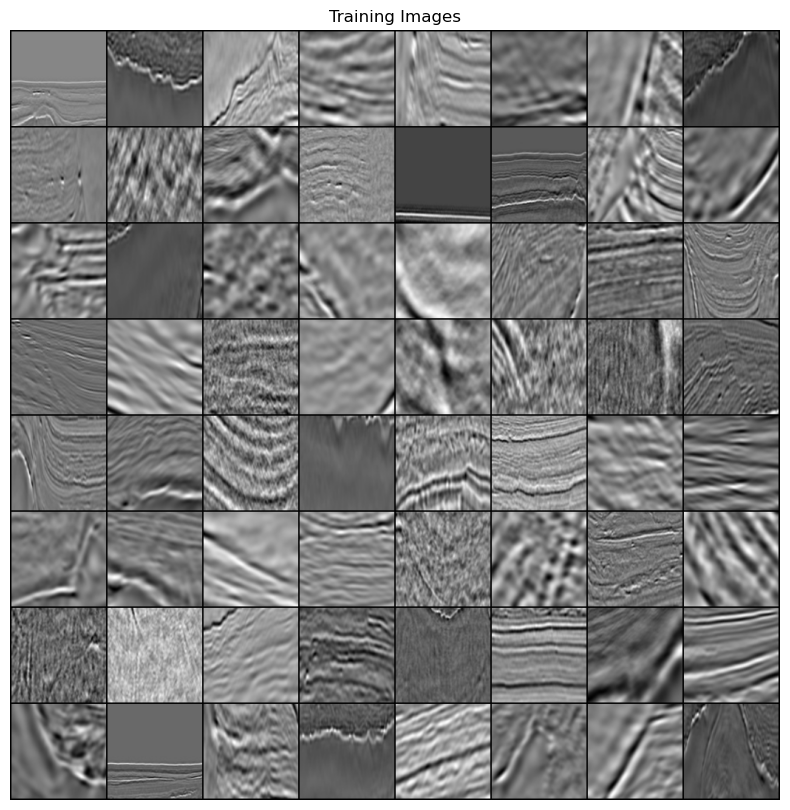

In [9]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(cfg.DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Init UNet, Loss Function and Optimizer

In [10]:
# initialize our UNet model
unet = UNet().to(cfg.DEVICE)

# initialize loss function and optimizer
loss_func = nn.BCEWithLogitsLoss()
opt = optim.Adam(unet.parameters(), lr=cfg.INIT_LR)

# calculate steps per epoch for training and test set
train_steps = len(train_ds) // cfg.BATCH_SIZE
test_steps = len(test_ds) // cfg.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

## Train

In [11]:
# loop over epochs
print("[INFO] Training the network...")
startTime = time.time()
for e in tqdm(range(cfg.NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	
	# training loop
	for (i, (x, y)) in enumerate(train_loader):
		# send the input to the device
		(x, y) = (x.to(cfg.DEVICE), y.to(cfg.DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = loss_func(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in test_loader:
			# send the input to the device
			(x, y) = (x.to(cfg.DEVICE), y.to(cfg.DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += loss_func(pred, y)
	
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / train_steps
	avgTestLoss = totalTestLoss / test_steps
	
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, cfg.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] Training the network...


  0%|          | 0/40 [00:00<?, ?it/s]

[INFO] EPOCH: 1/40
Train loss: 0.588264, Test loss: 0.6146
[INFO] EPOCH: 2/40
Train loss: 0.569510, Test loss: 0.5948
[INFO] EPOCH: 3/40
Train loss: 0.532078, Test loss: 0.5243
[INFO] EPOCH: 4/40
Train loss: 0.495290, Test loss: 0.5139
[INFO] EPOCH: 5/40
Train loss: 0.466119, Test loss: 0.5012
[INFO] EPOCH: 6/40
Train loss: 0.464387, Test loss: 0.4658
[INFO] EPOCH: 7/40
Train loss: 0.443318, Test loss: 0.6044
[INFO] EPOCH: 8/40
Train loss: 0.493336, Test loss: 0.5630
[INFO] EPOCH: 9/40
Train loss: 0.485362, Test loss: 0.4978
[INFO] EPOCH: 10/40
Train loss: 0.452034, Test loss: 0.4623
[INFO] EPOCH: 11/40
Train loss: 0.450131, Test loss: 0.4555
[INFO] EPOCH: 12/40
Train loss: 0.443540, Test loss: 0.4579
[INFO] EPOCH: 13/40
Train loss: 0.432925, Test loss: 0.4767
[INFO] EPOCH: 14/40
Train loss: 0.439943, Test loss: 0.4462
[INFO] EPOCH: 15/40
Train loss: 0.424557, Test loss: 0.4297
[INFO] EPOCH: 16/40
Train loss: 0.419122, Test loss: 0.5974
[INFO] EPOCH: 17/40
Train loss: 0.423742, Test lo

### Plot Training/Validation loss

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(cfg.PLOT_PATH)
# serialize the model to disk
torch.save(unet, cfg.MODEL_PATH)

## Predict

In [18]:
import cv2

In [19]:
def prepare_plot(orig_image, orig_mask, pred_mask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(orig_image)
	ax[1].imshow(orig_mask)
	ax[2].imshow(pred_mask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

def make_predictions(model, image_path):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(image_path)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = image_path.split(os.path.sep)[-1]
		gt_path = os.path.join(cfg.MASK_DATASET_PATH, filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gt_mask = Image.open(gt_path)
		gt_mask = gt_mask.resize((cfg.INPUT_IMAGE_HEIGHT, cfg.INPUT_IMAGE_HEIGHT))
		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(cfg.DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		pred_mask = model(image).squeeze()
		pred_mask = torch.sigmoid(pred_mask)
		pred_mask = pred_mask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		pred_mask = (pred_mask > cfg.THRESHOLD) * 255
		pred_mask = pred_mask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gt_mask, pred_mask)

[INFO] Loading up test image paths...


/tmp/ipykernel_61670/3301897844.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


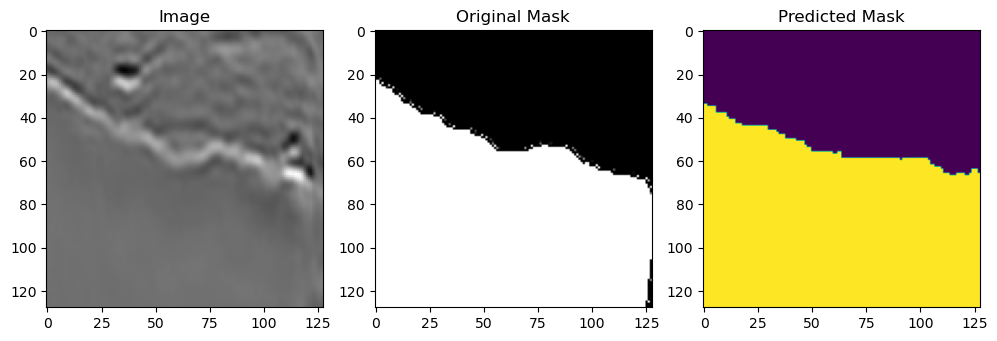

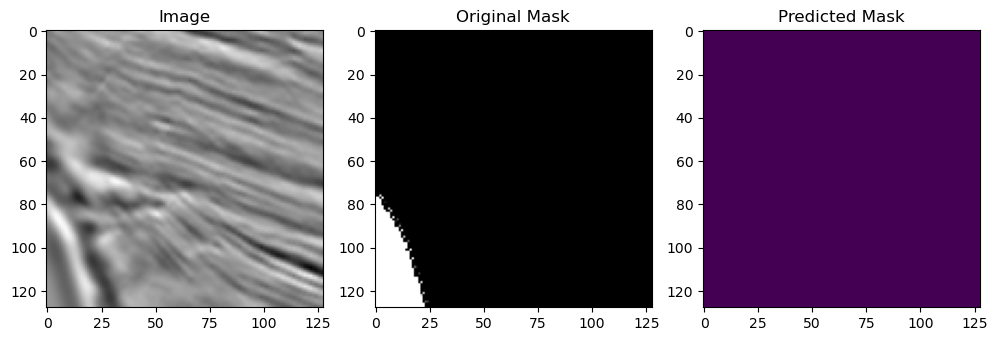

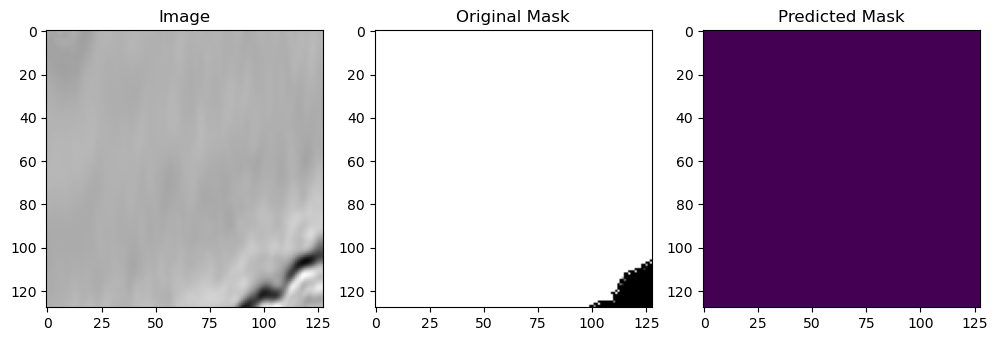

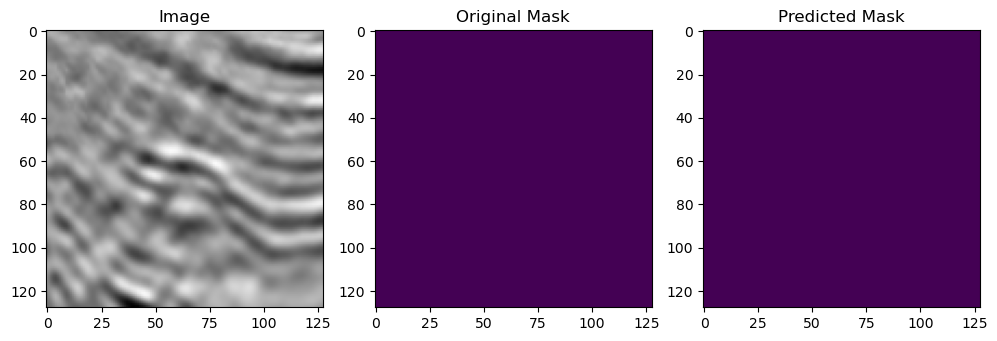

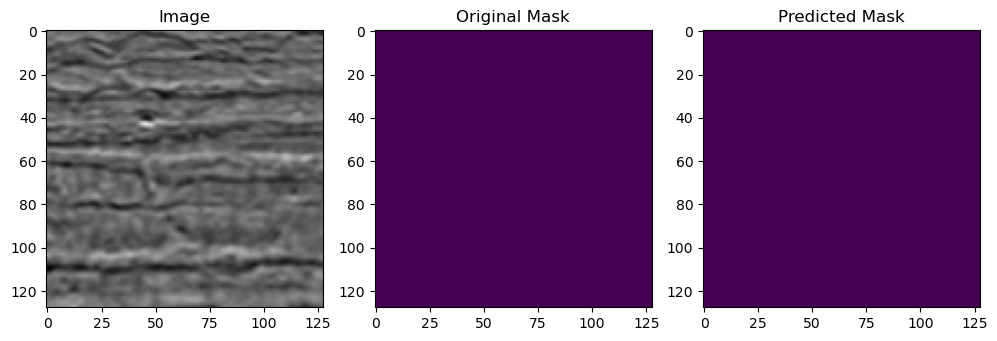

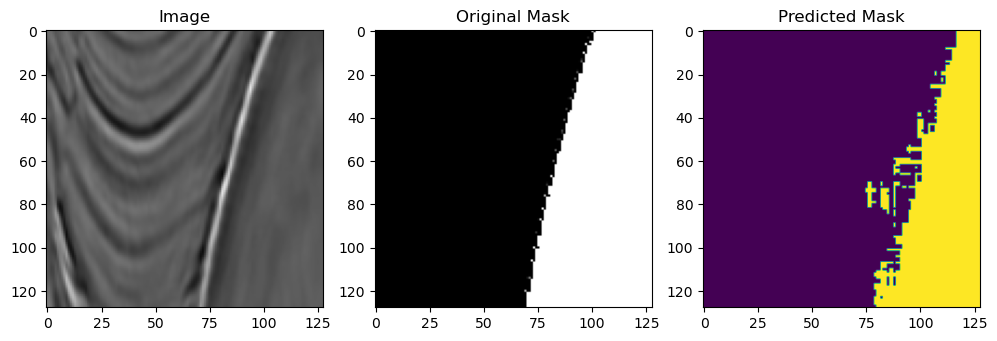

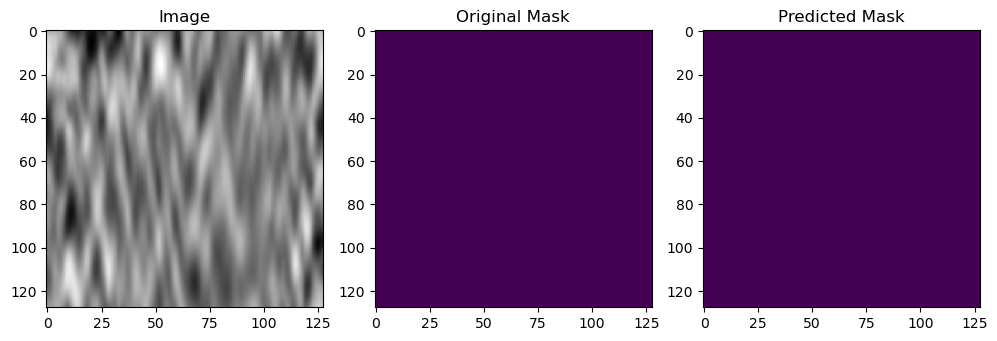

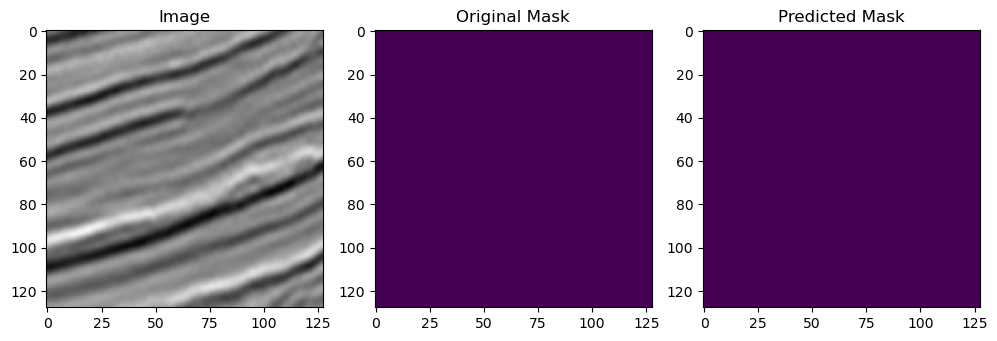

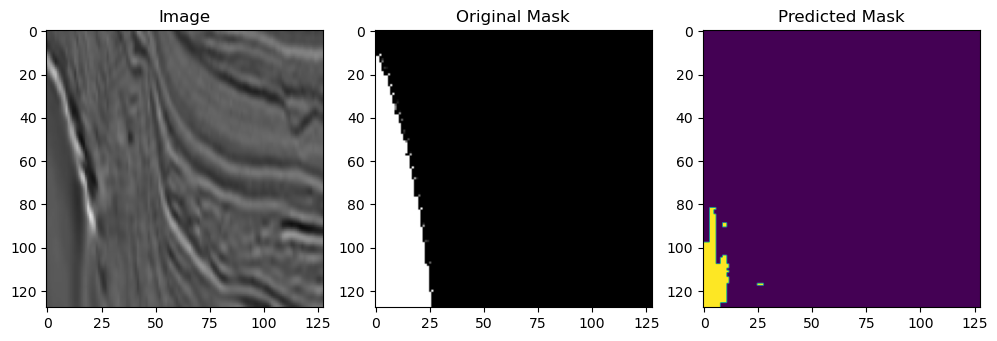

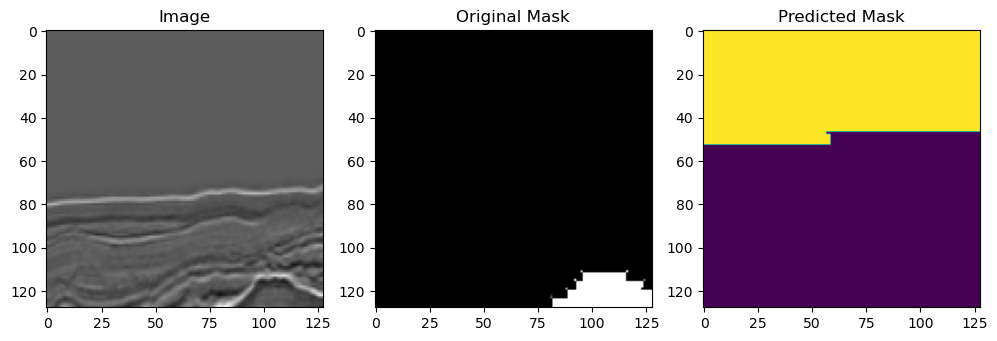

In [21]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] Loading up test image paths...")
imagePaths = open(cfg.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
# print("[INFO] Load up model...")
# unet = torch.load(cfg.MODEL_PATH).to(cfg.DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)

In [22]:
print(unet)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (main): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
      (1): Block(
        (main): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
      (2): Block(
        (main): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
    )
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoder): Decoder(
    (dec_blocks): ModuleList(
      (0): Block(
        (main): Sequential(
          (0): 